##### Расчетные материалы для презентации по анализу кампаний по сбору дебиторской задолженности

* презентация доступна по ссылке:
https://docs.google.com/presentation/d/1-Xp2cse6-5QxvRTrdlf3SYOabZ08XXz1Nhq8yBKoqCY/edit?usp=sharing


In [470]:
import pandas as pd
import numpy as np
import datetime 
from matplotlib import pyplot as plt
import scipy.stats as sps
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots

#### Загрузим таблицы и проведем первичное исследование данных в каждом массиве:

In [122]:
d1 = pd.read_excel('data_.xlsx', sheet_name='p_1')
d2 = pd.read_excel('data_.xlsx', sheet_name='p_2')
d3 = pd.read_excel('data_.xlsx', sheet_name='p_3')
d4 = pd.read_excel('data_.xlsx', sheet_name='p_4')

##### Исследуем датафрейм d1:

In [66]:
d1.head(3)

camp_id  camp_date channel group_type  client_id  delivery  open
0     1234 2021-03-05   email         ЦГ    1003262       1.0   1.0
1     1234 2021-03-05   email         ЦГ    1006668       NaN   NaN
2     1234 2021-03-05   email         ЦГ    1007636       NaN   NaN

In [63]:
print('Компании (кол-во,id): ',d1.camp_id.nunique(),d1.camp_id.unique())
print('Даты: ',d1.camp_date.nunique(),d1.camp_date.unique())
print('Каналы: ',d1.channel.nunique(),d1.channel.unique())
print('Типы групп: ',d1.group_type.nunique(),d1.group_type.unique())
print('Кол-во клиентов: ',d1.client_id.nunique())

Компании (кол-во,id):  2 [1234 1243]
Даты:  2 ['2021-03-05T00:00:00.000000000' '2021-03-07T00:00:00.000000000']
Каналы:  2 ['email' 'SMS']
Типы групп:  2 ['ЦГ' 'КГ']
Кол-во клиентов:  1400


In [364]:
#проверяем на пересечение абонентов в участии в кампаниях
d_em = d1.loc[(d1.group_type=='ЦГ')&(d1.channel=='email')]
id_em = set(d_em.client_id.to_list()) # перечень id абонентов участвовавших в email-рассылке
d_sms = d1.loc[(d1.group_type=='ЦГ')&(d1.channel=='SMS')]
id_sms = set(d_sms.client_id.to_list())  # перечень id абонентов участвовавших в sms-рассылке
print(f'Количество общих абонентов в кампаниях: {len(id_sms&id_em)}')

Количество общих абонентов в кампаниях: 0


In [272]:
# агрегируем исходный ДФ и найдем кол-во абонентов участвующих, получивших сообщения, открывших сообщения по категориальным признакам 
# вычислим конверсии на данных этапах
d_descr = d1.groupby(['camp_date','camp_id','group_type','channel']).agg(
    {'client_id':'count','delivery':'sum','open':'sum'}).reset_index()
d_descr['conv_delivery'] = d_descr.apply(lambda x: x['delivery']/x['client_id']*100,axis=1)
d_descr['conv_open_participant'] = d_descr.apply(lambda x: x['open']/x['client_id']*100,axis=1)
d_descr['conv_open_delivery'] = d_descr.apply(lambda x: round(x['open']/x['delivery']*100,1) if x['delivery']!=0 else 0,axis=1)
d_descr

camp_date  camp_id group_type channel  client_id  delivery   open  \
0 2021-03-05     1234         КГ   email        100       0.0    0.0   
1 2021-03-05     1234         ЦГ   email        500     478.0  363.0   
2 2021-03-07     1243         КГ     SMS        200       0.0    0.0   
3 2021-03-07     1243         ЦГ     SMS        600     585.0  552.0   

   conv_delivery  conv_open_participant  conv_open_delivery  
0            0.0                    0.0                 0.0  
1           95.6                   72.6                75.9  
2            0.0                    0.0                 0.0  
3           97.5                   92.0                94.4

In [414]:
# 'достанем' из сводного ДФ количество участников по каждой акции 
id_em_participant = d_descr.loc[(d_descr.channel=='email')&(d_descr.group_type=='ЦГ')].client_id.to_list()[0]
id_sms_participant = d_descr.loc[(d_descr.channel=='SMS')&(d_descr.group_type=='ЦГ')].client_id.to_list()[0]

##### построим график конверсий по обоим кампаниям

In [492]:
d_bar = d_descr[d_descr['group_type']=='ЦГ']
d_bar = d_bar[['channel','conv_delivery','conv_open_participant','conv_open_delivery']]
x = d_bar.columns[1:].to_list()
y_email = d_bar.iloc[0][1:].to_list()
y_sms = d_bar.iloc[1][1:].to_list()

In [493]:
print(x)

['conv_delivery', 'conv_open_participant', 'conv_open_delivery']


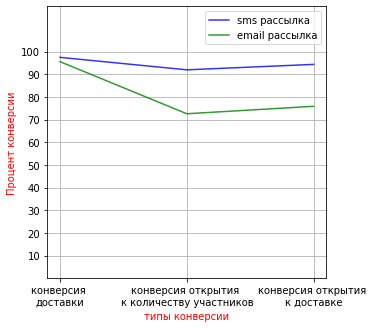

In [744]:
plt.figure(figsize=(5,5))
plt.plot(x,y_sms,color='b',alpha=0.8,label='sms рассылка')
plt.plot(x,y_email,color='g',alpha=0.8,label='email рассылка')
plt.ylabel('Процент конверсии',color='r')
plt.xlabel('типы конверсии',color='r')
plt.ylim((0,120))
plt.xticks(x, ['конверсия \nдоставки','конверсия открытия \nк количеству участников','конверсия открытия \nк доставке'])
plt.yticks(range(10,110,10))
plt.legend()
plt.grid()
plt.savefig('conv_1.png')
plt.show()

##### участвовало
- email рассылка: 500 абонентов
- SMS рассылка: 600 абонентов

##### доставлено
- email рассылка: 478 сообщений
- SMS рассылка: 585 сообщений

##### открыто
- email рассылка: 363 сообщений
- SMS рассылка: 552 сообщений

##### Было проведено две кампании:
1) 5 марта 2021 (код кампании 1234)
- информирование происходило посредством email рассылок
- контрольная группа составила 100 абонентов, целевая группа - 500 абонентов
- конверсия доставки информации составила 95%, открыли сообщения 72% участников и 76% доставленных сообщений  

2) 7 марта 2021 (код кампании 1243)
- информирование происходило посредством SMS рассылок
- контрольная группа составила 200 абонентов, целевая группа - 600 абонентов
- конверсия доставки информации составила 97%, открыли сообщения 92% участников и 94% доставленных сообщений  

#### Таким образом:
- эффективность кампании, основанной на SMS рассылке показала свое преимущество, а именно: 
- эффективность доставки сообщений выше,хотя и незначительно  (на 2%)
- эффективность открытия сообщений $значительно$ выше (как по отношению к доставленным, так и по отношению к общему количеству участников и стотавила практически  20% в обоих случаях)

###### Однозначно можно сделать вывод о том, что:
- кампания с помощью SMS рассылок наиболее эффективна и обеспечивает конверсию более 90%
- общих участников в кампаниях не было

##### Исследуем датафрейм d2:

In [65]:
d2.head(3)

client_id  debt_date  debt_sum
0    1000431 2021-03-01       820
1    1000530 2021-03-01       833
2    1001465 2021-03-01       819

In [69]:
print('Даты:',d2.debt_date.unique()) 
print('Кол-во клиентов:',d2.client_id.nunique())

Даты: ['2021-03-01T00:00:00.000000000']
Кол-во клиентов: 1960


In [495]:
sns_plot = sns.displot(data=d2,x='debt_sum', bins=1000,kde=True,stat="density")
# plt.title(f'Статистическое распределение суммы долга \nна начало кампании: {str(d2.debt_date.unique()[0])[:10]}',
#           color='r',
#           fontsize=15)
plt.ylabel("Относительно количество абонентов в выборке в %")
plt.xlabel("Сумма долга абонентов")
plt.savefig('debt_stat.png')
plt.show()

На графике построена гистограмма плотности распределения суммы долга на дату начала кампании (в выборке участвуют 1960 абонентов)
##### Распределение задолженности абонентов на начало кампании носит следующий характер:
- сумма долга колеблется от 800 до 900 рублей
- сглаженное статистическое распределение можно оценить по сплошной линии, оно носит относительно гладкий характер с незначительным увеличением количества абонентов при сумме 810 и 885 руб. и снижением количества в максимальных и минимальных значениях (800 и 900 руб. соответственно)
- пиковые выбросы статистики дискретны, скорее всего связаны с покупкой стандартных пакетов, у которых стоимость для большого количества абонентов одинакова


##### Исследуем датафрейм d3:

In [68]:
d3.head(3)

client_id payment_date  payment_sum
0    1957013   2021-03-07        805.0
1    1718544   2021-03-07        881.0
2    1862730   2021-03-07        895.0

In [72]:
print('Кол-во клиентов:',d2.client_id.nunique())
print('Мин и макс даты:',d3.payment_date.min(), d3.payment_date.max())
print('Даты в выборке:\n',d3.payment_date.unique())
print('Кол-во клиентов по датам, общая выручка и средний чек:')
d3_gr = d3.groupby(['payment_date']).agg({'client_id':'count','payment_sum':'sum'})
d3_gr['av_check'] = d3_gr.apply(lambda x: round(x['payment_sum']/x['client_id'],2),axis=1)
d3_av_check = d3_gr.reset_index()
d3_av_check 

Кол-во клиентов: 1960
Мин и макс даты: 2021-03-05 00:00:00 2021-03-13 00:00:00
Даты в выборке:
 ['2021-03-07T00:00:00.000000000' '2021-03-05T00:00:00.000000000'
 '2021-03-13T00:00:00.000000000' '2021-03-10T00:00:00.000000000']
Кол-во клиентов по датам, общая выручка и средний чек:


payment_date  client_id  payment_sum  av_check
0   2021-03-05        292     288160.0    986.85
1   2021-03-07        251     236572.0    942.52
2   2021-03-10        259     292394.0   1128.93
3   2021-03-13        109      92673.0    850.21

##### разделим датасет на три выборки: 
- участники email-кампании 
- участники sms-кампании
- не участвовали ни в одной из кампаний

In [372]:
d3_em = d3.loc[d3.client_id.isin(id_em)]
print(f'Количество платежей от абонентов, участвовавших в email-кампании: {d3_em.client_id.nunique()}')
d3_sms = d3.loc[d3.client_id.isin(id_sms)]
print(f'Количество платежей от абонентов, участвовавших в SMS-кампании: {d3_sms.client_id.nunique()}')
d3_others = d3.loc[(~d3.client_id.isin(id_em))&(~d3.client_id.isin(id_sms))]
print(f'Количество платежей от абонентов, не участвовавших в кампании: {d3_others.client_id.nunique()}')

Количество платежей от абонентов, участвовавших в email-кампании: 250
Количество платежей от абонентов, участвовавших в SMS-кампании: 200
Количество платежей от абонентов, не участвовавших в кампании: 461


In [376]:
d3_em_gr = d3_em.groupby(['payment_date']).agg({'client_id':'count','payment_sum':'sum'})
d3_em_gr['av_check'] = d3_em_gr.apply(lambda x: round(x['payment_sum']/x['client_id'],2),axis=1)
d3_em_av_check = d3_em_gr.reset_index()
print('Платежи участников email-кампании: ')
d3_em_av_check 

Платежи участников email-кампании: 


payment_date  client_id  payment_sum  av_check
0   2021-03-05        250     252393.0   1009.57

In [377]:
d3_sms_gr = d3_sms.groupby(['payment_date']).agg({'client_id':'count','payment_sum':'sum'})
d3_sms_gr['av_check'] = d3_sms_gr.apply(lambda x: round(x['payment_sum']/x['client_id'],2),axis=1)
d3_sms_av_check = d3_sms_gr.reset_index()
print('Платежи участников SMS-кампании: ')
d3_sms_av_check 

Платежи участников SMS-кампании: 


payment_date  client_id  payment_sum  av_check
0   2021-03-07        200     192838.0    964.19

In [415]:
conv_sms_participant = round(d3_sms.client_id.nunique()/id_sms_participant*100,2)
conv_em_participant = round(d3_em.client_id.nunique()/id_em_participant*100,2)
print(f'Конверсия платежей участников email-кампании: {conv_em_participant}')
print(f'Конверсия платежей участников SMS-кампании: {conv_sms_participant}')
d_conv_pay = pd.DataFrame({'channel':['email','SMS'],
                           'conv_payment_participant':[conv_em_participant,conv_sms_participant]})
d_conv_pay

Конверсия платежей участников email-кампании: 50.0
Конверсия платежей участников SMS-кампании: 33.33


channel  conv_payment_participant
0   email                     50.00
1     SMS                     33.33

In [403]:
d3_others_gr = d3_others.groupby(['payment_date']).agg({'client_id':'count','payment_sum':'sum'})
d3_others_gr['av_check'] = d3_others_gr.apply(lambda x: round(x['payment_sum']/x['client_id'],2),axis=1)
d3_others_av_check = d3_others_gr.reset_index()
print('Платежи абонентов, не участвовавших в кампаниях: ')
d3_others_av_check 

Платежи абонентов, не участвовавших в кампаниях: 


payment_date  client_id  payment_sum  av_check
0   2021-03-05         42      35767.0    851.60
1   2021-03-07         51      43734.0    857.53
2   2021-03-10        259     292394.0   1128.93
3   2021-03-13        109      92673.0    850.21

In [562]:
#вспомогательный ДФ для постороения графиков по датам
df_graph = d3_others_av_check.merge(d3_em_av_check,on='payment_date',how='outer').merge(d3_sms_av_check,on='payment_date',how='outer')
df_graph

payment_date  client_id_x  payment_sum_x  av_check_x  client_id_y  \
0   2021-03-05           42        35767.0      851.60        250.0   
1   2021-03-07           51        43734.0      857.53          NaN   
2   2021-03-10          259       292394.0     1128.93          NaN   
3   2021-03-13          109        92673.0      850.21          NaN   

   payment_sum_y  av_check_y  client_id  payment_sum  av_check  
0       252393.0     1009.57        NaN          NaN       NaN  
1            NaN         NaN      200.0     192838.0    964.19  
2            NaN         NaN        NaN          NaN       NaN  
3            NaN         NaN        NaN          NaN       NaN

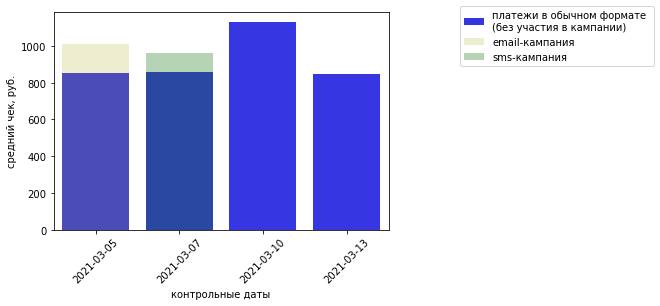

In [676]:

f1 = sns.barplot(data=d3_others_av_check,x='payment_date',y='payment_sum',color='b',alpha=0.9,
                 label='платежи в обычном формате \n(без участия в кампании)')
sns.barplot(data=df_graph,x='payment_date',y='payment_sum_y',color='y',alpha=0.2,
                 label='email-кампания')
sns.barplot(data=df_graph,x='payment_date',y='payment_sum',color='g',alpha=0.3,
                 label='sms-кампания')
f1.set_xlabel('контрольные даты')
f1.set_ylabel('общая сумма платежей, руб.')
d = [str(i)[:10] for i in d3_others_av_check.payment_date.to_list()]
f1.set_xticklabels(d,rotation = 45)
# plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.savefig('stat_payment.png')
plt.show()

f2 = sns.barplot(data=d3_others_av_check,x='payment_date',y='av_check',color='b',alpha=0.9,
                 label='платежи в обычном формате \n(без участия в кампании)')
sns.barplot(data=df_graph,x='payment_date',y='av_check_y',color='y',alpha=0.2,
                 label='email-кампания')
sns.barplot(data=df_graph,x='payment_date',y='av_check',color='g',alpha=0.3,
                 label='sms-кампания')
f2.set_xlabel('контрольные даты')
f2.set_ylabel('средний чек, руб.')
f2.set_xticklabels(d,rotation = 45)
plt.legend(bbox_to_anchor=(1.2, 1.05))
plt.savefig('stat_av_check.png')
plt.show()

##### на графиках видим,что email-кампания лидирует как 
- по среднему чеку, так и 
- по общему объему платежей 

#### составим ДФ для воронки продаж по каждой из кампаний

In [587]:
d_conv = d_descr.loc[d_descr.group_type=='ЦГ'][['camp_date',
                                                'channel',
                                                'client_id',
                                                'conv_delivery',
                                                'conv_open_participant']]
d_conv['conv_participant'] = 100
d_conv = d_conv.merge(d_conv_pay,on='channel').T.reset_index().rename(columns={'0':'email'})
d_conv

index                    0                    1
0                 camp_date  2021-03-05 00:00:00  2021-03-07 00:00:00
1                   channel                email                  SMS
2                 client_id                  500                  600
3             conv_delivery                 95.6                 97.5
4     conv_open_participant                 72.6                 92.0
5          conv_participant                  100                  100
6  conv_payment_participant                 50.0                33.33

In [599]:
x_funnel_em = sorted(d_conv[0][3:].to_list(), reverse=True)
x_funnel_sms = sorted(d_conv[1][3:].to_list(), reverse=True)
y_funnel = ['конверсия участия','конверсия доставки','конверсия открытия сообщения','конверсия оплаты']#d_conv['index'][3:].to_list()

In [610]:
## plotly
data_em = dict(values=x_funnel_em,stages=y_funnel)
data_sms = dict(values=x_funnel_sms,stages=y_funnel)

fige = px.funnel(data_em, y='stages', x='values',text='stages')
# fige.update_layout(title="Воронка email кампании", xaxis_title="конверсия",yaxis_title="этапы")
fige.save('email_funnel.png')
fige.show()

figs = px.funnel(data_sms, y='stages', x='values',text='stages')
# figs.update_layout(title="Воронка SMS кампании", xaxis_title="конверсия в процентах",yaxis_title="этапы")
plt.savefig('sms_funnel.png')
figs.show()

- несмотря на то, SMS-сообщения доходят до абонентов быствее и легче, конверсия на последнем, и самом важном этапе (оплате задолженности) у получателей email-сообщений выше почти на 20%
- этот эффект можно отнести к более серьезному подходу абонентов к сообщениям на электронную почту, SMS-сообщения воспринимаются пользователями как спам и игнорируются, либо забываются в суете текущих проблем

##### Исследуем датафрейм d4:

In [73]:
d4.head(3)

client_id   app_date      app_reason
0    1005770 2021-03-06  запрос баланса
1    1006087 2021-03-08  запрос баланса
2    1006596 2021-03-06  запрос баланса

In [75]:
print('Виды обращений:',d4.app_reason.unique())
print('Кол-во клиентов:',d4.client_id.nunique())
print('Кол-во дат и перечень дат:',d4.app_date.nunique(),'\n',d4.app_date.unique())
print('Сводная по датам - кол-во клиентов по каждому виду обращений:')
d4_gr_date = d4.groupby(['app_date','app_reason'])['client_id'].nunique().reset_index()
d4_gr_date 

Виды обращений: ['запрос баланса' 'диагностика роутера' 'диагностика приставки']
Кол-во клиентов: 478
Кол-во дат и перечень дат: 6 
 ['2021-03-06T00:00:00.000000000' '2021-03-08T00:00:00.000000000'
 '2021-03-11T00:00:00.000000000' '2021-03-14T00:00:00.000000000'
 '2021-03-03T00:00:00.000000000' '2021-03-05T00:00:00.000000000']
Сводная по датам - кол-во клиентов по каждому виду обращений:


app_date             app_reason  client_id
0  2021-03-03  диагностика приставки         20
1  2021-03-03    диагностика роутера         11
2  2021-03-03         запрос баланса         31
3  2021-03-05  диагностика приставки         20
4  2021-03-05    диагностика роутера          9
5  2021-03-05         запрос баланса         54
6  2021-03-06  диагностика приставки          7
7  2021-03-06    диагностика роутера         10
8  2021-03-06         запрос баланса         73
9  2021-03-08  диагностика приставки         20
10 2021-03-08    диагностика роутера         15
11 2021-03-08         запрос баланса        109
12 2021-03-11  диагностика приставки          4
13 2021-03-11    диагностика роутера         11
14 2021-03-11         запрос баланса         67
15 2021-03-14  диагностика приставки          2
16 2021-03-14    диагностика роутера          1
17 2021-03-14         запрос баланса         14

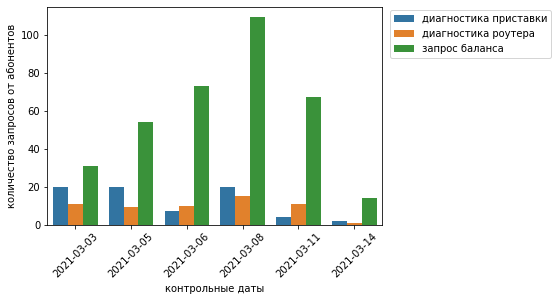

In [697]:
# построим бар-чарт по исходному массиву данных  
f1 = sns.barplot(data=d4_gr_date,x='app_date',y='client_id',hue='app_reason')#, palette='pastel')
f1.set_xlabel('контрольные даты')
f1.set_ylabel('количество запросов от абонентов')
d = [str(j)[:10] for j in sorted([str(i) for i in set(d4_gr_date.app_date.to_list())])]
# d = [str(i)[:10] for i in set(d4_gr_date.app_date.to_list())]
f1.set_xticklabels(d,rotation = 45)
plt.legend(bbox_to_anchor=(1.52,1.01))
plt.savefig('stat_request.png')
plt.show()

##### разделим датасет на три выборки: 
- участники email-кампании 
- участники sms-кампании
- не участвовали ни в одной из кампаний

In [699]:
d4_em = d4.loc[d4.client_id.isin(id_em)]
print(f'Запросы от абонентов, участвовавших в email-кампании: {d4_em.client_id.nunique()}')
d4_sms = d4.loc[d4.client_id.isin(id_sms)]
print(f'Запросы от абонентов, участвовавших в SMS-кампании: {d4_sms.client_id.nunique()}')
d4_others = d4.loc[(~d4.client_id.isin(id_em))&(~d4.client_id.isin(id_sms))]
print(f'Запросы от абонентов, не участвовавших в кампании: {d4_others.client_id.nunique()}')

Запросы от абонентов, участвовавших в email-кампании: 127
Запросы от абонентов, участвовавших в SMS-кампании: 141
Запросы от абонентов, не участвовавших в кампании: 210


In [702]:
d4_gr_date_others = d4_others.groupby(['app_date','app_reason'])['client_id'].nunique().reset_index()
f1 = sns.barplot(data=d4_gr_date_others,x='app_date',y='client_id',hue='app_reason')#, palette='pastel')
f1.set_title('Запросы от абонентов \nне участвовавших в кампаниях',color='b')
f1.set_xlabel('контрольные даты')
f1.set_ylabel('количество запросов от абонентов')
d = [str(j)[:10] for j in sorted([str(i) for i in set(d4_gr_date_others.app_date.to_list())])]
# d = [str(i)[:10] for i in set(d4_gr_date.app_date.to_list())]
f1.set_xticklabels(d,rotation = 45)
plt.legend(bbox_to_anchor=(1.52,1.01))
plt.savefig('stat_request_others.png')
plt.show()

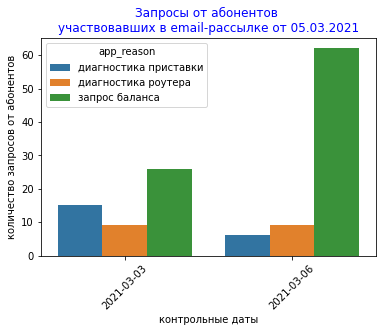

In [742]:
d4_gr_date_em = d4_em.groupby(['app_date','app_reason'])['client_id'].nunique().reset_index()
f1 = sns.barplot(data=d4_gr_date_em,x='app_date',y='client_id',hue='app_reason')#, palette='pastel')
f1.set_title('Запросы от абонентов \nучаствовавших в email-рассылке от 05.03.2021',color='b')
f1.set_xlabel('контрольные даты')
f1.set_ylabel('количество запросов от абонентов')
d = [str(j)[:10] for j in sorted([str(i) for i in set(d4_gr_date_em.app_date.to_list())])]
# d = [str(i)[:10] for i in set(d4_gr_date.app_date.to_list())]
f1.set_xticklabels(d,rotation = 45)
# plt.legend(bbox_to_anchor=(1.52,1.01))
plt.savefig('stat_request_email.png')
plt.show()

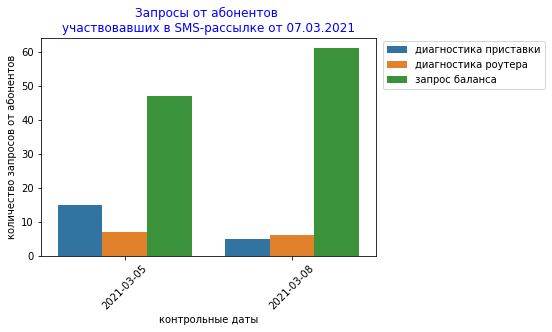

In [743]:
d4_gr_date_sms = d4_sms.groupby(['app_date','app_reason'])['client_id'].nunique().reset_index()
f1 = sns.barplot(data=d4_gr_date_sms,x='app_date',y='client_id',hue='app_reason')#, palette='pastel')
f1.set_title('Запросы от абонентов \nучаствовавших в SMS-рассылке от 07.03.2021',color='b')
f1.set_xlabel('контрольные даты')
f1.set_ylabel('количество запросов от абонентов')
d = [str(j)[:10] for j in sorted([str(i) for i in set(d4_gr_date_sms.app_date.to_list())])]
# d = [str(i)[:10] for i in set(d4_gr_date.app_date.to_list())]
f1.set_xticklabels(d,rotation = 45)
plt.legend(bbox_to_anchor=(1.52,1.01))
plt.savefig('stat_request_sms.png')
plt.show()

#####  процент увеличения количества запросов после акции информирования абонентов составил:

In [741]:
n_sms_befor = d4_gr_date_sms.loc[(d4_gr_date_sms.app_reason=='запрос баланса')&(d4_gr_date_sms.app_date=='2021-03-05')]['client_id'].to_list()[0]
n_sms_after = d4_gr_date_sms.loc[(d4_gr_date_sms.app_reason=='запрос баланса')&(d4_gr_date_sms.app_date=='2021-03-08')]['client_id'].to_list()[0]
increase_req_sms = round(n_sms_after/n_sms_befor*100,1)
print(f'- SMS-рассылки: {increase_req_sms}%')

- SMS-рассылки: 129.8%


In [740]:
n_em_befor = d4_gr_date_em.loc[(d4_gr_date_em.app_reason=='запрос баланса')&(d4_gr_date_em.app_date=='2021-03-03')]['client_id'].to_list()[0]
n_em_after = d4_gr_date_em.loc[(d4_gr_date_em.app_reason=='запрос баланса')&(d4_gr_date_em.app_date=='2021-03-06')]['client_id'].to_list()[0]
increase_req_em = round(n_em_after/n_em_befor*100,1)
print(f'- email-рассылки: {increase_req_em}%')

- email-рассылки: 238.5%
